**Analyse des signaux SSVEP**

Importations des bibliothèques et fichiers

In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
origin = "../SSVEP_data/"
file = "26"

In [6]:
timing = np.loadtxt(os.path.join(origin,file,"time.txt"),delimiter = ',',dtype = 'datetime64[ms]')
consignes = np.loadtxt(os.path.join(origin,file,"consignes.txt"),delimiter = ',',dtype = str)
logs = np.loadtxt(os.path.join(origin,file,"essai.txt"),delimiter = ',')

In [8]:
raw_eeg = np.genfromtxt(os.path.join(origin,file,"{}.txt".format(file)),delimiter =',',skip_header = 5)
eeg = np.transpose(raw_eeg)
data = eeg[1:5]
n_channels = 4
ch_names=['Fpz','O2','Oz','O1']
ch_types=['eog','eeg','eeg','eeg']
f_e=200 #Hz
info_data=mne.create_info(ch_names,ch_types=ch_types,sfreq=f_e)
print(info_data)
time=np.linspace(0,(1/f_e)*data.shape[1],data.shape[1]) #variable temps
#création du type Array
raw=mne.io.RawArray(data,info_data)
#set montage
montage=mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage,match_case=True)

<Info | 7 non-empty values
 bads: []
 ch_names: Fpz, O2, Oz, O1
 chs: 1 EOG, 3 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 4
 projs: []
 sfreq: 200.0 Hz
>
Creating RawArray with float64 data, n_channels=4, n_times=292719
    Range : 0 ... 292718 =      0.000 ...  1463.590 secs
Ready.


/tmp/ipykernel_5806/838093039.py:15: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['Fpz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage,match_case=True)


<RawArray | 4 x 292719 (1463.6 s), ~8.9 MB, data loaded>

1er Affichage

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)



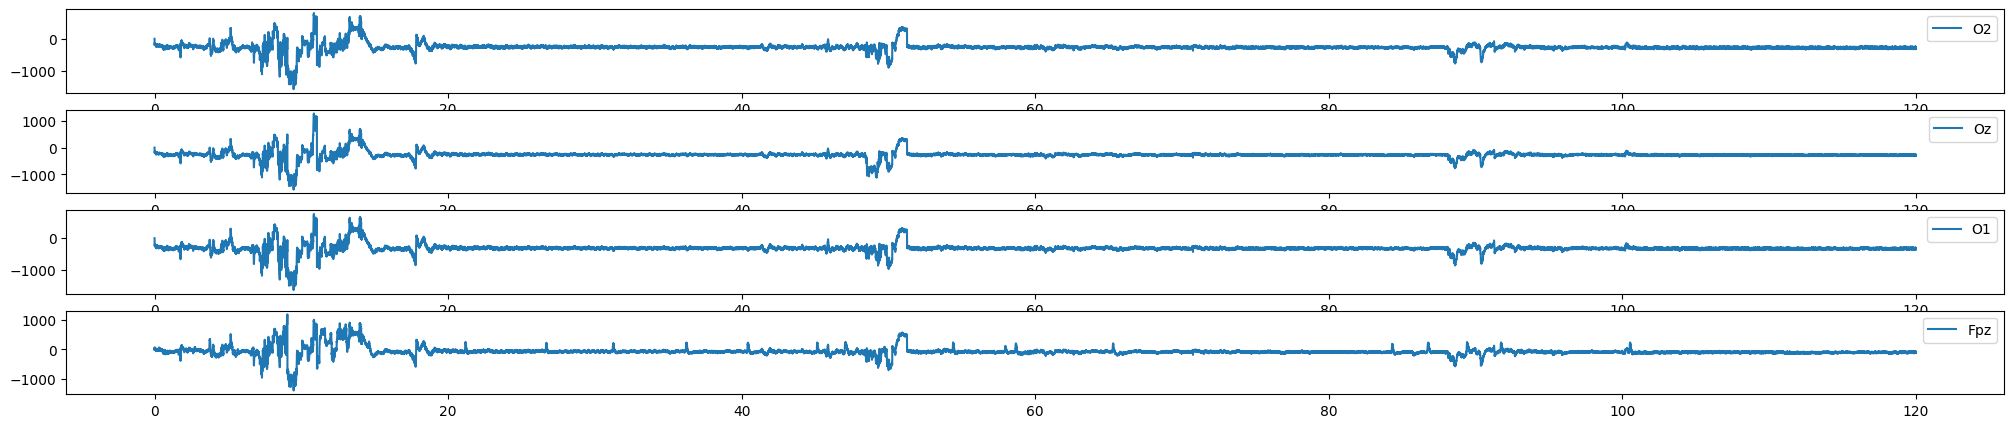

In [9]:
eeg_array = raw.get_data()
mne.filter.notch_filter(eeg_array,200,50)
#fenêtre d'affichage
debut=0
fin=60*2
f_e=int(raw.info['sfreq'])
time=raw.times[debut*f_e:fin*f_e]
amplitude_1=eeg_array[0][debut*f_e:fin*f_e]
amplitude_2=eeg_array[1][debut*f_e:fin*f_e]
amplitude_3=eeg_array[2][debut*f_e:fin*f_e]
amplitude_4=eeg_array[3][debut*f_e:fin*f_e]

plt.figure(figsize=(25,5))
plt.subplot(4,1,1)
plt.plot(time,amplitude_2,label="O2")
plt.legend()

plt.subplot(4,1,2)
plt.plot(time,amplitude_3,label="Oz")
plt.legend()

plt.subplot(4,1,3)
plt.plot(time,amplitude_4,label="O1")
plt.legend()

plt.subplot(4,1,4)
plt.plot(time,amplitude_1,label="Fpz")
plt.legend()


plt.show()

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)



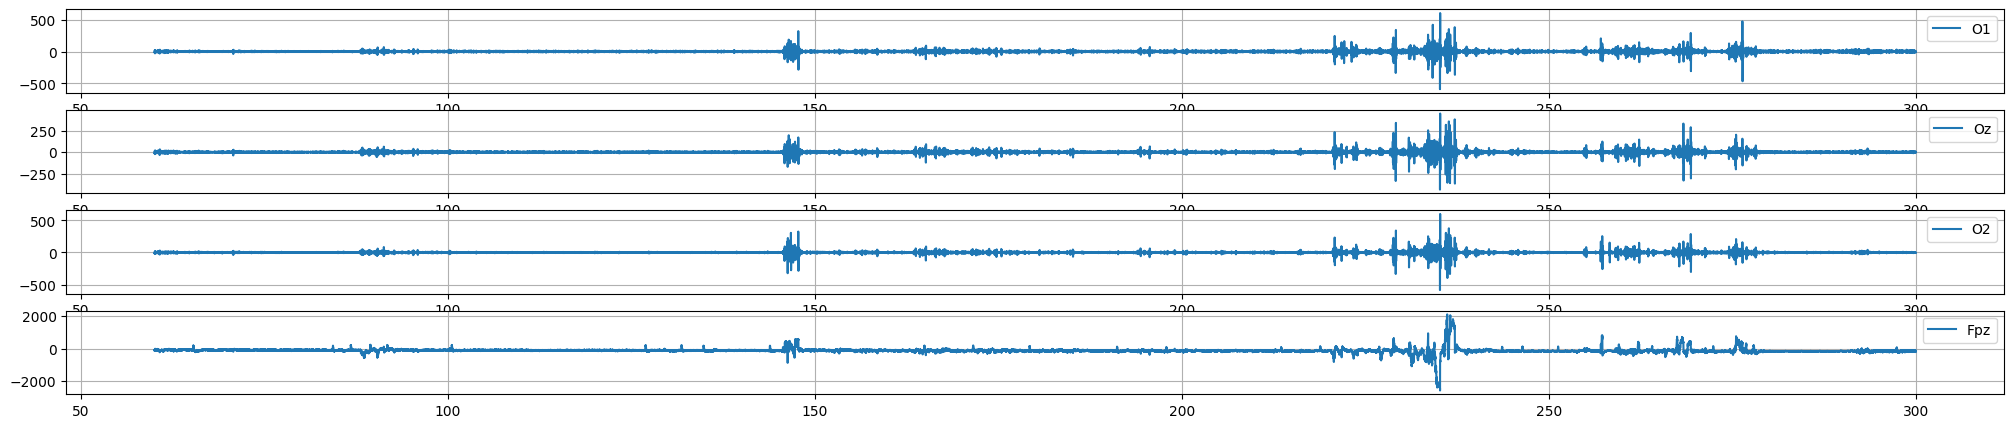

In [10]:
raw.filter(l_freq=11,h_freq=25,fir_design='firwin',verbose=False)
eeg_array = raw.get_data()
mne.filter.notch_filter(eeg_array,200,50)
#fenêtre d'affichage
debut=60
fin=5*60
f_e=int(raw.info['sfreq'])
time=raw.times[debut*f_e:fin*f_e]
amplitude_1=eeg_array[0][debut*f_e:fin*f_e]
amplitude_2=eeg_array[1][debut*f_e:fin*f_e]
amplitude_3=eeg_array[2][debut*f_e:fin*f_e]
amplitude_4=eeg_array[3][debut*f_e:fin*f_e]

plt.figure(figsize=(25,5))
plt.subplot(4,1,1)
plt.plot(time,amplitude_2,label="O1")
plt.grid()
plt.legend()

plt.subplot(4,1,2)
plt.plot(time,amplitude_3,label="Oz")
plt.grid()
plt.legend()

plt.subplot(4,1,3)
plt.plot(time,amplitude_4,label="O2")
plt.grid()
plt.legend()

plt.subplot(4,1,4)
plt.plot(time,amplitude_1,label="Fpz")
plt.grid()
plt.legend()


plt.show()

**Nettoyage du signal (artefacts EOG et ECG) grâce à une ICA**

In [11]:
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs)
raw.load_data()

<RawArray | 4 x 292719 (1463.6 s), ~8.9 MB, data loaded>

Using EOG channel: Fpz
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 54 significant peaks
Number of EOG events detected: 54
Not setting metadata
54 matching events found
No baseline correction applied
Using data from preloaded Raw for 54 events and 201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
No projector specified for this 

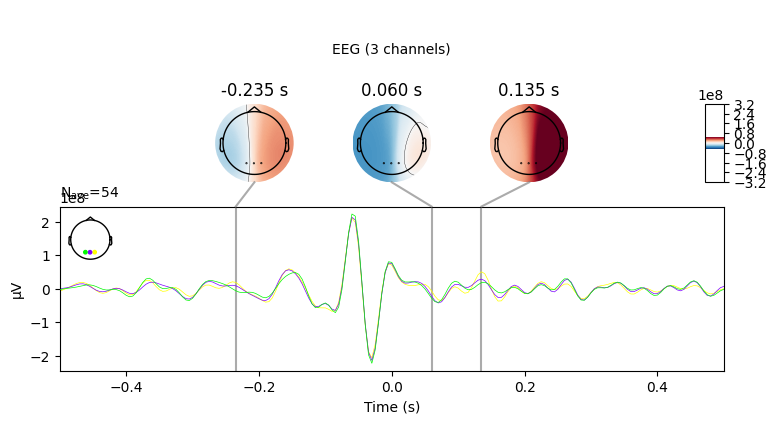

Using channel Oz to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2000 samples (10.000 sec)

Number of ECG events detected : 556 (average pulse 22 / min.)
Not setting metadata
556 matching events found
No baseline correction applied
Using data from preloaded Raw for 556 events and 201 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.


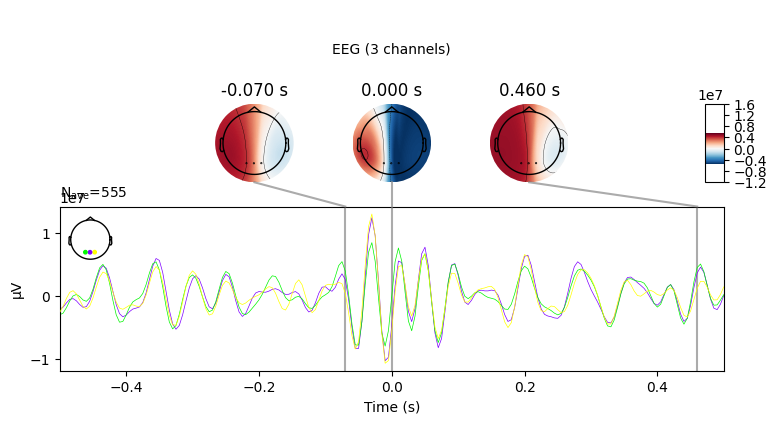

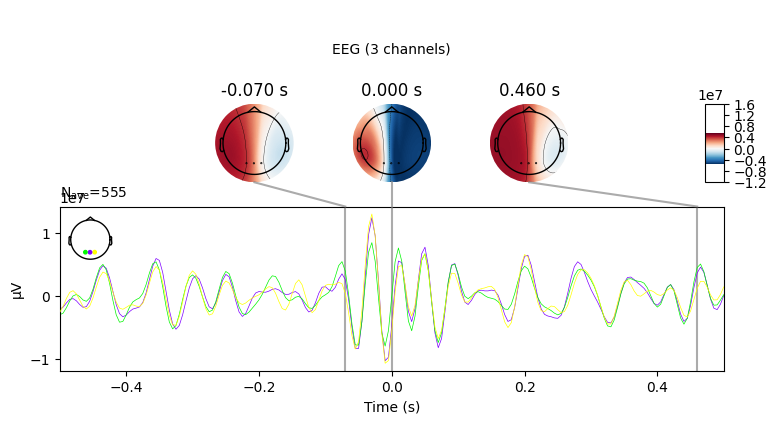

In [12]:
#summary of eog and ecg artefacts
eog_evoked = create_eog_epochs(raw).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()
ecg_evoked = create_ecg_epochs(raw,ch_name='Oz').average()
ecg_evoked.apply_baseline(baseline=(None, -0.2))
ecg_evoked.plot_joint()

In [14]:
#we keep a copy of the unfiltered Raw object around so we can apply the ICA solution to it later.
filt_raw = raw.copy().filter(l_freq=1., h_freq=None)

ica = ICA(n_components=3, max_iter='auto', random_state=None)
ica.fit(filt_raw)
ica

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 sec)

Fitting ICA to data using 3 channels (please be patient, this may take a while)
Selecting by number: 3 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


Fitting ICA took 0.3s.


Method,fastica
Fit,1 iterations on raw data (292719 samples)
ICA components,3
Explained variance,100.0 %
Available PCA components,3
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=4, n_times=393822
    Range : 0 ... 393821 =      0.000 ...  1969.105 secs
Ready.
Using matplotlib as 2D backend.
Opening ica-browser...


c:\Users\cassa\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


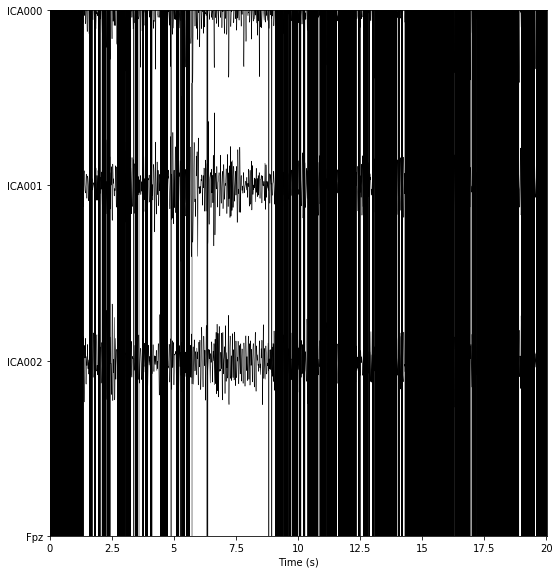

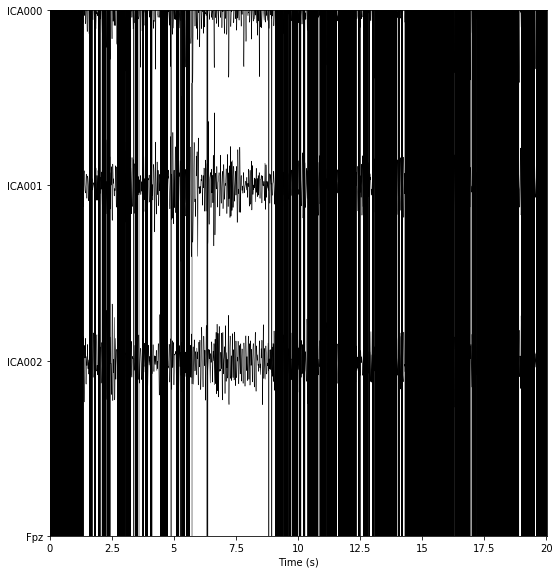

In [11]:
filt_raw.load_data()
ica.plot_sources(filt_raw, show_scrollbars=False)

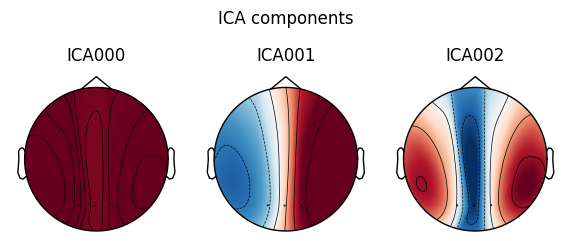

[<MNEFigure size 585x260.5 with 3 Axes>]

In [15]:
ica.plot_components()

Applying ICA to Raw instance
    Transforming to ICA space (3 components)
    Zeroing out 1 ICA component
    Projecting back using 3 PCA components


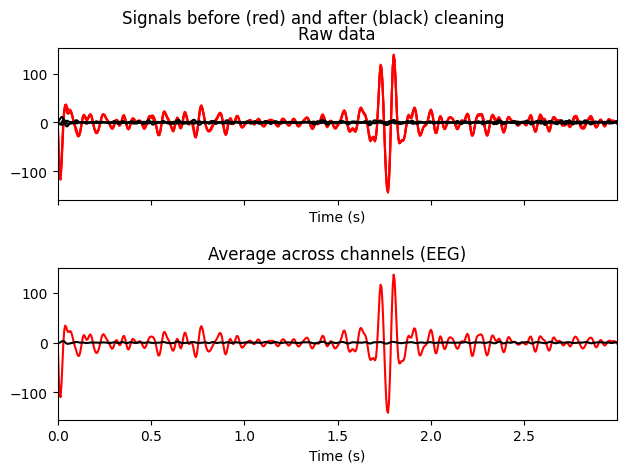

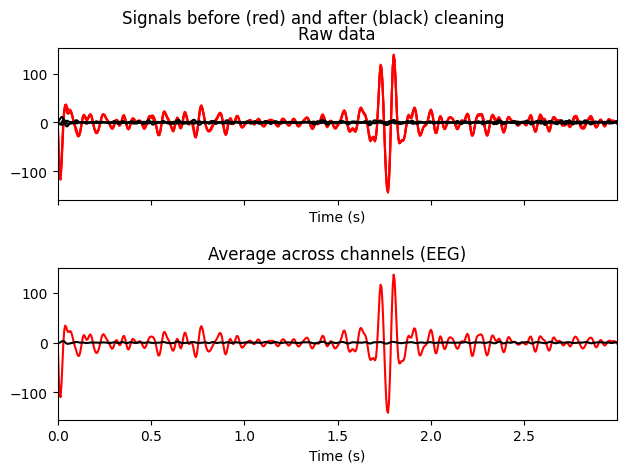

In [16]:
# blinks
ica.plot_overlay(filt_raw, exclude=[0], picks='eeg')
# heartbeats
#ica.plot_overlay(raw, exclude=[1])

Applying ICA to Raw instance
    Transforming to ICA space (3 components)
    Zeroing out 1 ICA component
    Projecting back using 3 PCA components
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwid

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


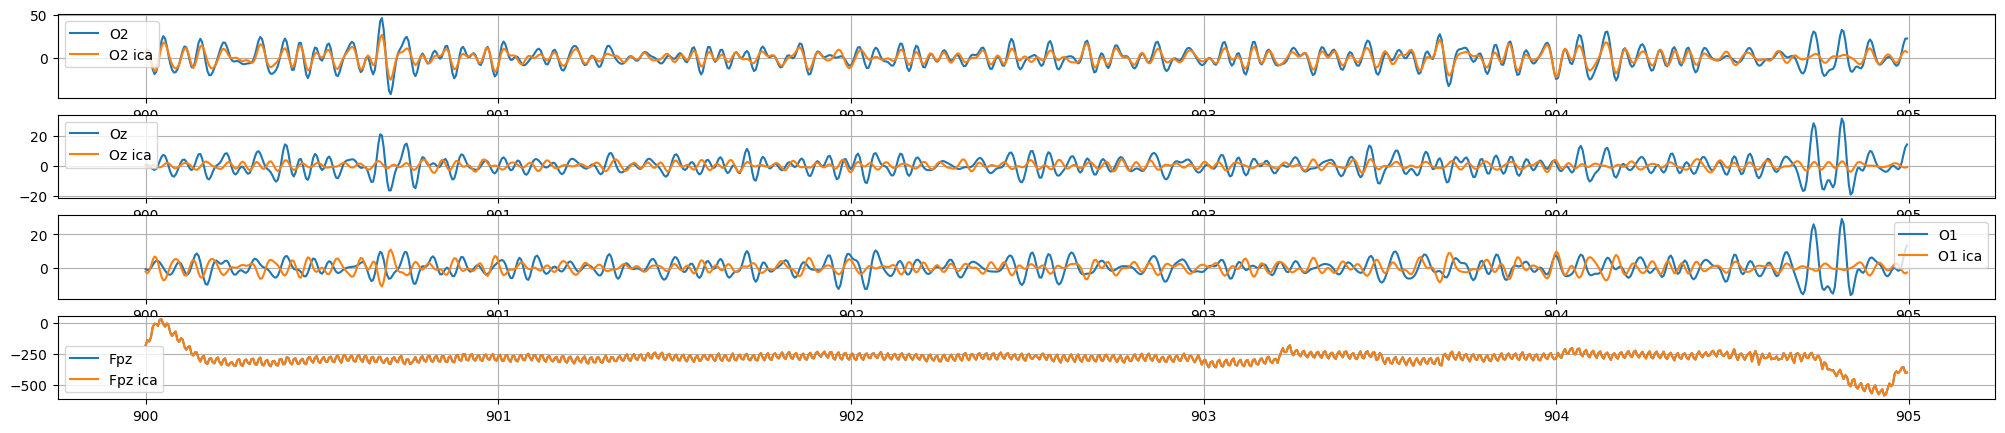

In [17]:
#on applique l'ica au filt_raw
ica.exclude=[0]
ica.apply(filt_raw)


eeg_array = raw.get_data()
eeg_ica = filt_raw.get_data()
mne.filter.notch_filter(eeg_array,200,50)
mne.filter.notch_filter(eeg_ica,200,50)

#fenêtre d'affichage
debut=60*15
fin=5 + 60*15
f_e=int(raw.info['sfreq'])
time=raw.times[debut*f_e:fin*f_e]
amplitude_1=eeg_array[0][debut*f_e:fin*f_e]
amplitude_2=eeg_array[1][debut*f_e:fin*f_e]
amplitude_3=eeg_array[2][debut*f_e:fin*f_e]
amplitude_4=eeg_array[3][debut*f_e:fin*f_e]

amplitude_1ica=eeg_ica[0][debut*f_e:fin*f_e]
amplitude_2ica=eeg_ica[1][debut*f_e:fin*f_e]
amplitude_3ica=eeg_ica[2][debut*f_e:fin*f_e]
amplitude_4ica=eeg_ica[3][debut*f_e:fin*f_e]

plt.figure(figsize=(25,5))
plt.subplot(4,1,1)
plt.plot(time,amplitude_2,label="O2")
plt.plot(time,amplitude_2ica,label="O2 ica")
plt.grid()
plt.legend()

plt.subplot(4,1,2)
plt.plot(time,amplitude_3,label="Oz")
plt.plot(time,amplitude_3ica,label="Oz ica")

plt.grid()
plt.legend()

plt.subplot(4,1,3)
plt.plot(time,amplitude_4,label="O1")
plt.plot(time,amplitude_4ica,label="O1 ica")

plt.grid()
plt.legend()

plt.subplot(4,1,4)
plt.plot(time,amplitude_1,label="Fpz")
plt.plot(time,amplitude_1ica,label="Fpz ica")

plt.grid()
plt.legend()


plt.show()

**Densités spectrales de puissance**

Effective window size : 10.240 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


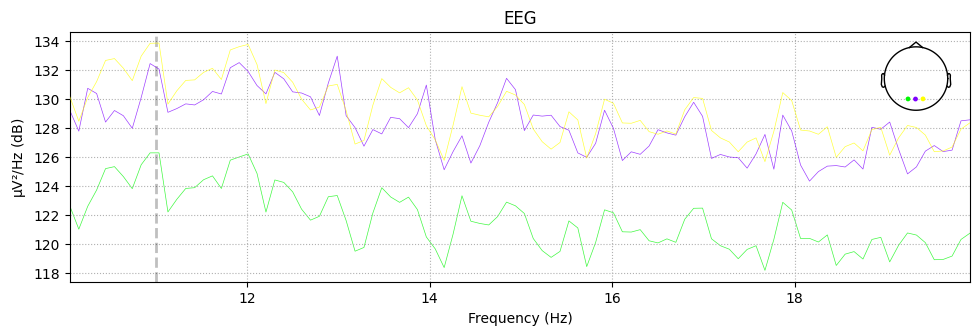

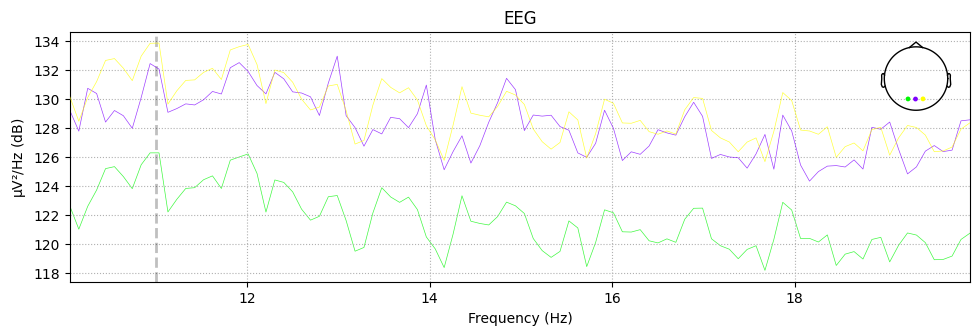

In [18]:
filt_raw.plot_psd(fmin=10,fmax=20)
#on voie l'impact du filtre passe bande initial et du notch à 50 Hz

In [20]:
#fonction qui retourne la fréquence du bouton observé à l'instant k
def freq_to_check(k):
    if consignes[k]=='droite':
        return(logs[k][1])
    if consignes[k]=='gauche':
        return(logs[k][0])

In [21]:
f_e = 200 #Hz fréquence d'échantillonnage
offset = 4

In [22]:
diff = []
for k in range(timing.shape[0]):
    diff.append(timing[k][1]-timing[k][0])
print(diff,"len",len(diff),np.mean(np.array(diff)))

[numpy.timedelta64(27334,'ms'), numpy.timedelta64(27028,'ms'), numpy.timedelta64(26714,'ms'), numpy.timedelta64(26916,'ms'), numpy.timedelta64(26493,'ms'), numpy.timedelta64(26601,'ms'), numpy.timedelta64(26425,'ms'), numpy.timedelta64(27106,'ms'), numpy.timedelta64(26813,'ms'), numpy.timedelta64(26565,'ms'), numpy.timedelta64(26333,'ms'), numpy.timedelta64(26437,'ms'), numpy.timedelta64(26273,'ms'), numpy.timedelta64(26792,'ms'), numpy.timedelta64(26405,'ms'), numpy.timedelta64(26663,'ms'), numpy.timedelta64(26701,'ms'), numpy.timedelta64(26631,'ms'), numpy.timedelta64(26729,'ms'), numpy.timedelta64(26692,'ms'), numpy.timedelta64(26677,'ms'), numpy.timedelta64(26611,'ms'), numpy.timedelta64(27077,'ms'), numpy.timedelta64(26867,'ms'), numpy.timedelta64(27174,'ms'), numpy.timedelta64(27377,'ms'), numpy.timedelta64(26982,'ms'), numpy.timedelta64(-165296,'ms'), numpy.timedelta64(-164672,'ms'), numpy.timedelta64(36432,'ms'), numpy.timedelta64(15040,'ms'), numpy.timedelta64(15008,'ms'), num

In [23]:
#repères temporels sur l'enregistrement EEG
offset = np.timedelta64(3,'s')
beginning = timing[0][0]-offset
print("début de l'enregistrement = ",beginning)
a=timing[0][0]-beginning
a = a.astype('timedelta64[s]').astype(np.int32)
print("le premier affichage a lieu à ",a," seconds")


début de l'enregistrement =  2022-06-27T17:13:12.450
le premier affichage a lieu à  3  seconds


In [24]:
#construction d'un tableau avec les repères temporels des affichages sur l'enregistrement EEG
reperes = np.zeros((timing.shape))
window_analysis = 4
for k in range(timing.shape[0]):
    reperes[k][0]=((timing[k][0]-beginning).astype('timedelta64[s]').astype(np.int32) + window_analysis)
    reperes[k][1]=((timing[k][1]-beginning).astype('timedelta64[s]').astype(np.int32) - window_analysis)
print(reperes)

[[7.00000000e+00 2.60000000e+01]
 [5.20000000e+01 7.10000000e+01]
 [9.70000000e+01 1.15000000e+02]
 [1.41000000e+02 1.60000000e+02]
 [1.86000000e+02 2.04000000e+02]
 [2.76000000e+02 2.94000000e+02]
 [3.20000000e+02 3.38000000e+02]
 [3.64000000e+02 3.84000000e+02]
 [4.10000000e+02 4.29000000e+02]
 [4.55000000e+02 4.73000000e+02]
 [5.45000000e+02 5.63000000e+02]
 [5.89000000e+02 6.07000000e+02]
 [6.33000000e+02 6.51000000e+02]
 [6.77000000e+02 6.95000000e+02]
 [7.21000000e+02 7.40000000e+02]
 [7.71000000e+02 7.89000000e+02]
 [8.15000000e+02 8.34000000e+02]
 [8.60000000e+02 8.79000000e+02]
 [9.05000000e+02 9.23000000e+02]
 [9.49000000e+02 9.68000000e+02]
 [9.94000000e+02 1.01200000e+03]
 [1.18400000e+03 1.20200000e+03]
 [1.22800000e+03 1.24700000e+03]
 [1.27300000e+03 1.29200000e+03]
 [1.31800000e+03 1.33700000e+03]
 [1.36300000e+03 1.38300000e+03]
 [1.40900000e+03 1.42700000e+03]
 [1.05047092e+09 1.05047075e+09]
 [1.05047092e+09 1.05047075e+09]
 [1.05047092e+09 1.05047095e+09]
 [1.050470

In [25]:
window = 0.3
frequency_bands=[10,12,13,14,15,16,17,18,20]

all_psd = np.zeros((timing.shape[0],len(frequency_bands)))
for k in range(timing.shape[0]):
    period = k
    for i in range(len(frequency_bands)):
        psds, freqs = mne.time_frequency.psd_welch(filt_raw,
                n_overlap=0, n_per_seg=None,
                tmin=reperes[period][0], tmax=reperes[period][1],
                fmin=frequency_bands[i]-window, fmax=frequency_bands[i]+window,
                window='boxcar',verbose=False)
        all_psd[k][i] = psds.mean()
#on construit un tableau ou pour chaque affichage (chaque ligne), on a les psd de toutes les fréquences

ValueError: No frequencies found between fmin=15.7 and fmax=16.3

In [26]:
#13 : k=0,2,5
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(frequency_bands,all_psd[0],color='lightgreen')
plt.plot(frequency_bands,all_psd[2],color='lightgreen')
plt.plot(frequency_bands,all_psd[5],color='lightgreen')
plt.title("3 runs à la fréquence de 13 Hz essai 1.1")
plt.subplot(2,1,2)
plt.plot(frequency_bands,all_psd[1],color='lightblue')
plt.plot(frequency_bands,all_psd[3],color='lightblue')
plt.plot(frequency_bands,all_psd[4],color='lightblue')
plt.title("3 runs à la fréquence de 17 Hz essai 1.1")

Text(0.5, 1.0, '3 runs à la fréquence de 17 Hz essai 1.1')

0
1
2
3
4
[1.04005979 1.16920724 1.28491966 1.14212984 1.37323139 0.
 0.         0.         0.        ] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


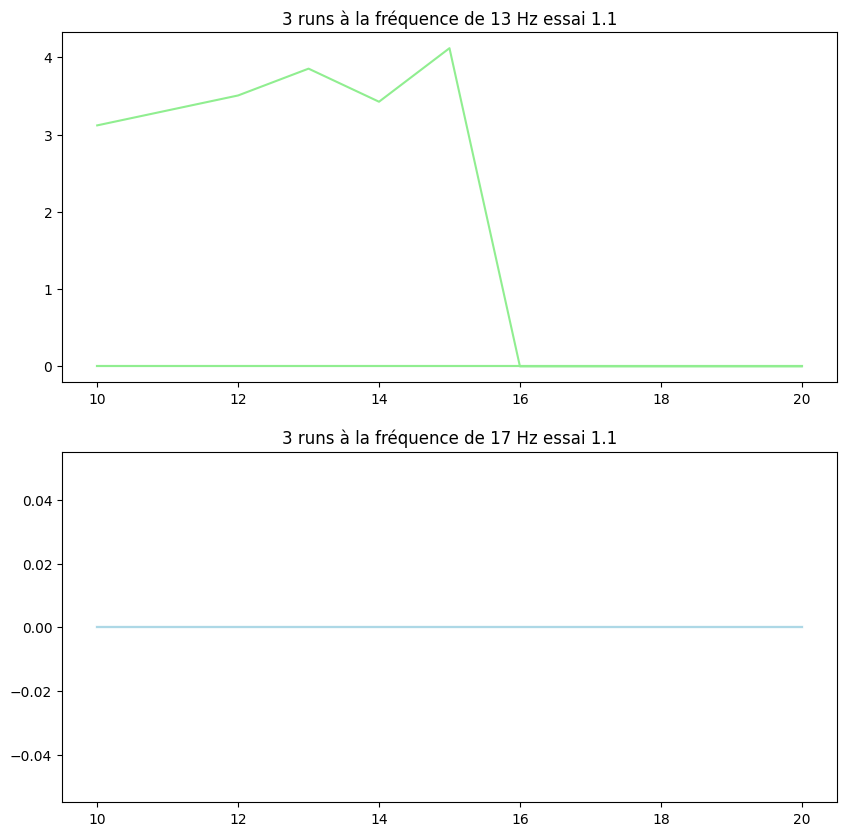

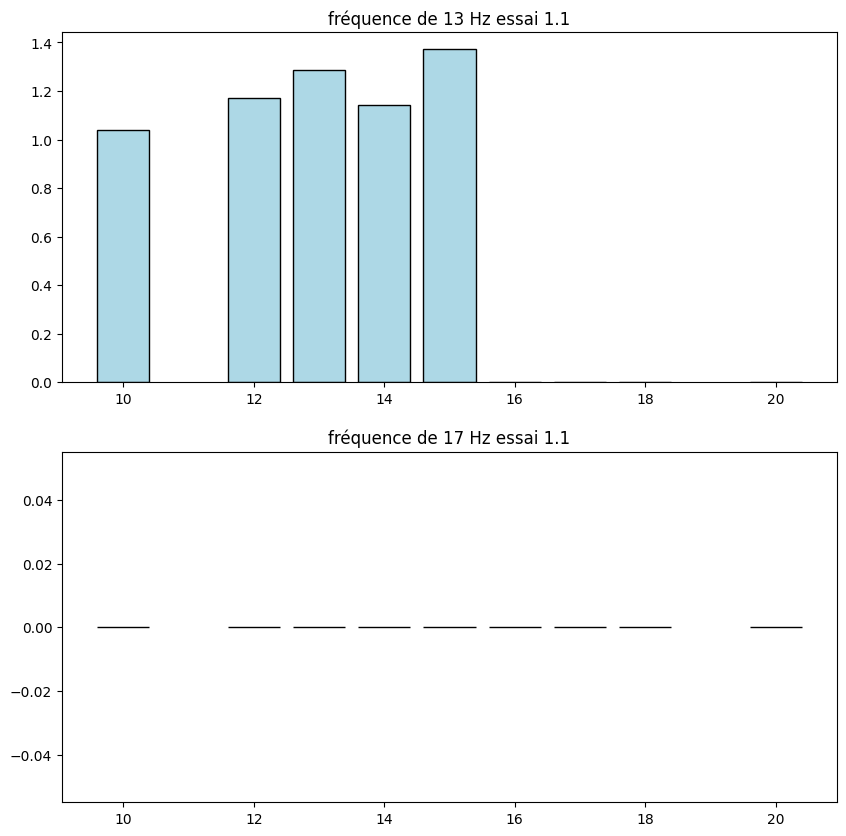

In [27]:
#moyenne pour l'essai 1.1
psds_13 = [0]*len(frequency_bands)
psds_17 = [0]*len(frequency_bands)
for k in range(6):
    if freq_to_check(k)==13:
        print(k)
        psds_13 += all_psd[k]
    if freq_to_check(k)==17:
        psds_17 += all_psd[k]
for i in range(len(frequency_bands)):
    psds_13[i]=psds_13[i]/3
    psds_17[i]=psds_17[i]/3

print(psds_13,psds_17)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.bar(frequency_bands,psds_13,color='lightblue',edgecolor='black')
plt.title("fréquence de 13 Hz essai 1.1")
plt.subplot(2,1,2)
plt.bar(frequency_bands,psds_17,color='lightgreen',edgecolor='black')
plt.title("fréquence de 17 Hz essai 1.1")
plt.show()
    

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0. 0. 0. 0. 0. 0. 0. 0. 0.]


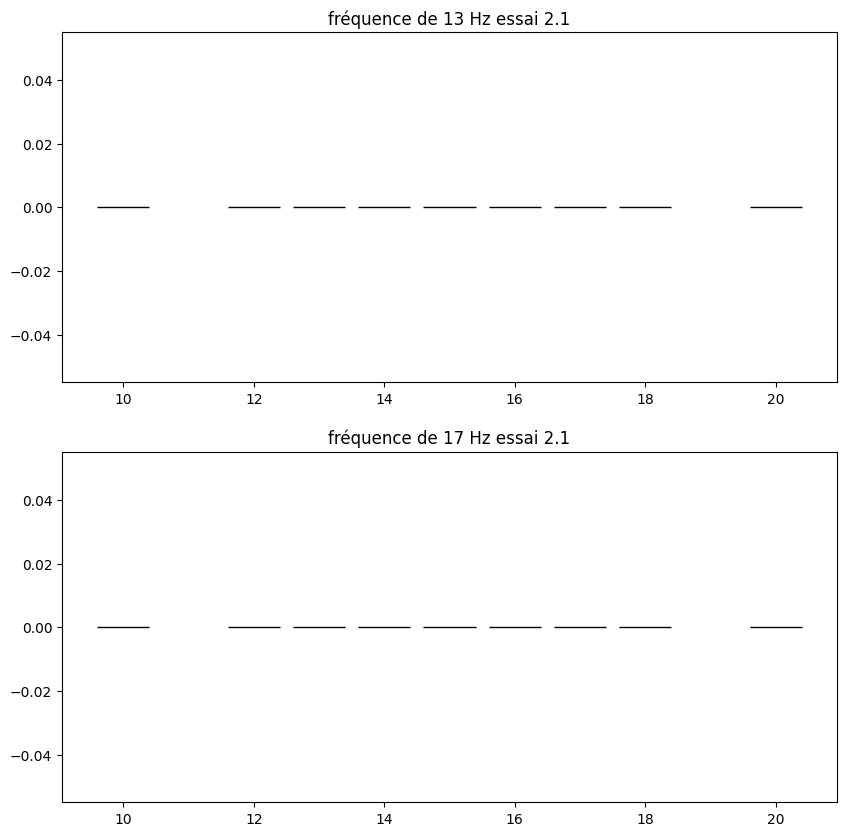

In [28]:
#moyenne pour l'essai 1.2
psds_13 = [0]*len(frequency_bands)
psds_17 = [0]*len(frequency_bands)
for k in range(6,12):
    if freq_to_check(k)==13:
        print(k)
        psds_13 += all_psd[k]
    if freq_to_check(k)==17:
        psds_17 += all_psd[k]
for i in range(len(frequency_bands)):
    psds_13[i]=psds_13[i]/3
    psds_17[i]=psds_17[i]/3 

print(psds_13,psds_17)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.bar(frequency_bands,psds_13,color='lightblue',edgecolor='black')
plt.title("fréquence de 13 Hz essai 2.1")
plt.subplot(2,1,2)
plt.bar(frequency_bands,psds_17,color='lightgreen',edgecolor='black')
plt.title("fréquence de 17 Hz essai 2.1")
plt.show()

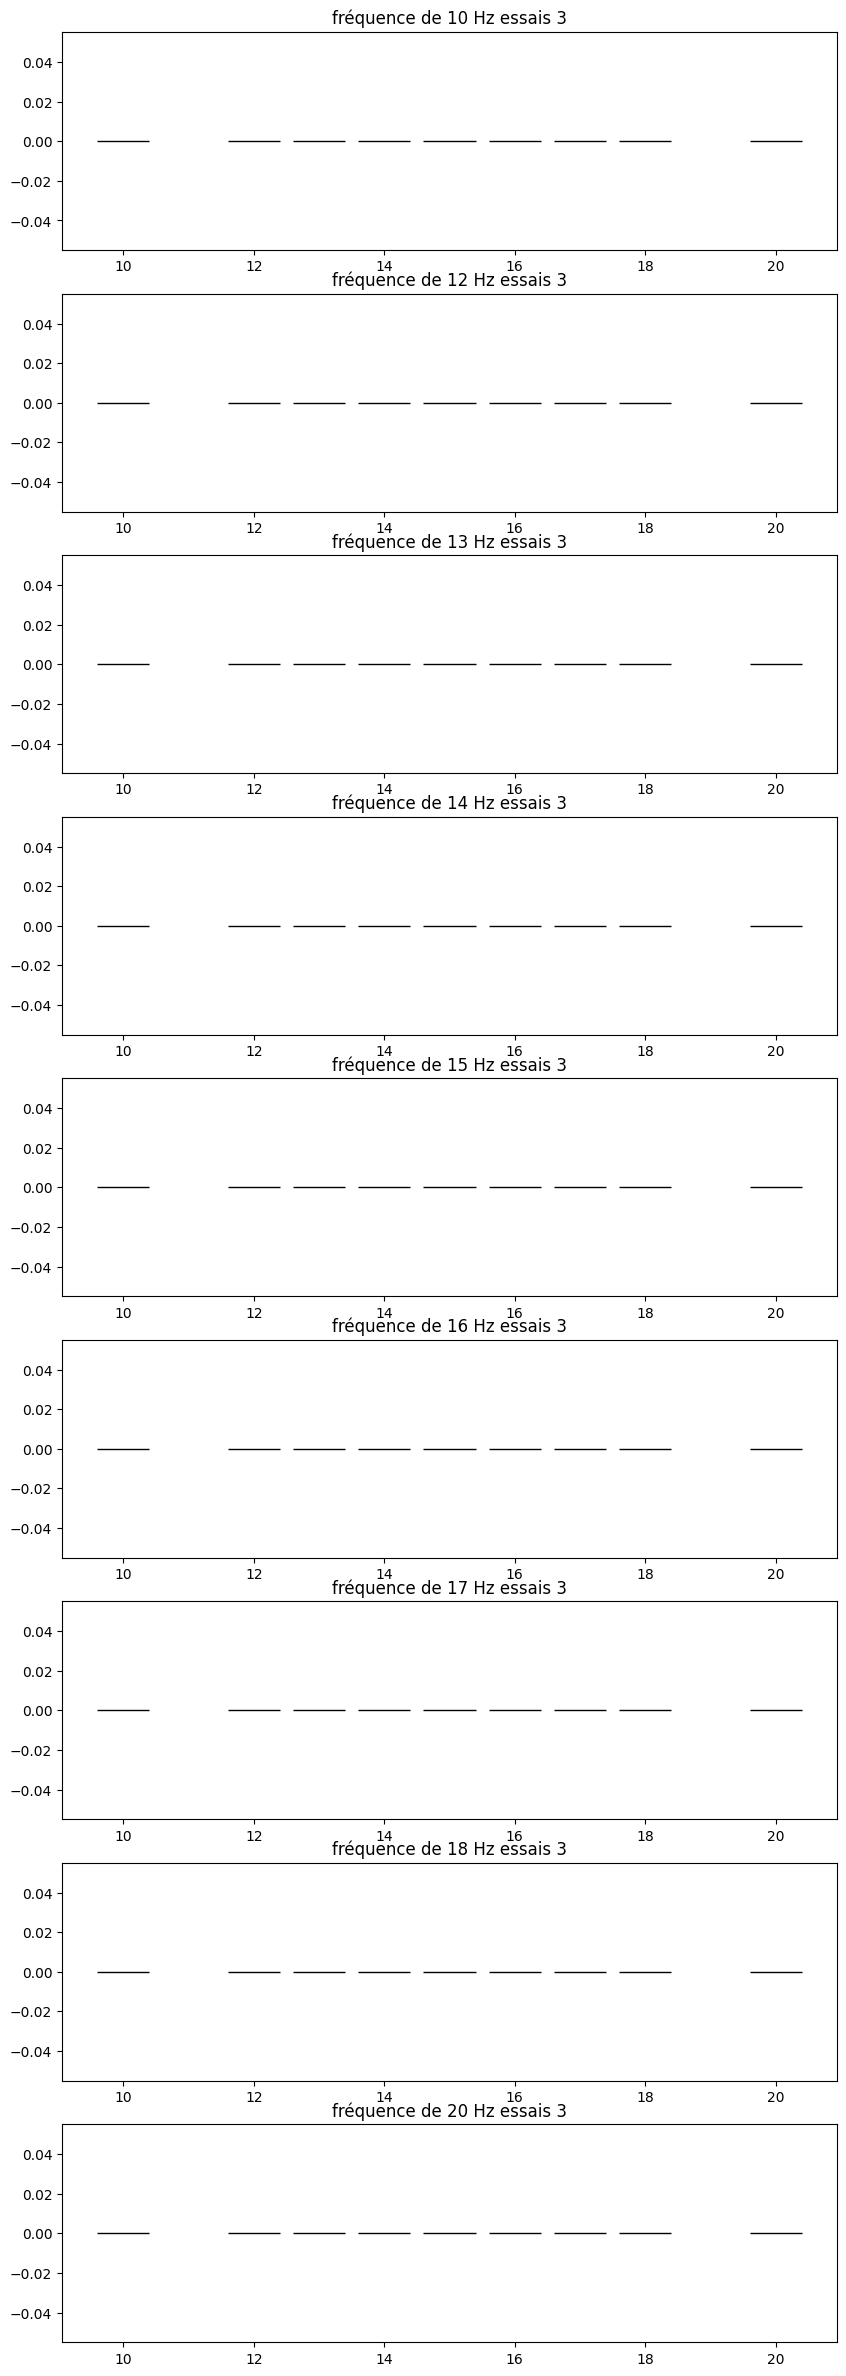

In [29]:
#moyennes pour les essais 3
psds_10 = [0]*len(frequency_bands)
psds_12 = [0]*len(frequency_bands)
psds_13 = [0]*len(frequency_bands)
psds_14 = [0]*len(frequency_bands)
psds_15 = [0]*len(frequency_bands)
psds_16 = [0]*len(frequency_bands)
psds_17 = [0]*len(frequency_bands)
psds_18 = [0]*len(frequency_bands)
psds_20 = [0]*len(frequency_bands)

for k in range(12,12+6*5):
    if freq_to_check(k)==10:
        psds_10 += all_psd[k]
    if freq_to_check(k)==12:
        psds_12 += all_psd[k]
    if freq_to_check(k)==13:
        psds_13 += all_psd[k]
    if freq_to_check(k)==14:
        psds_14 += all_psd[k]
    if freq_to_check(k)==15:
        psds_15 += all_psd[k]
    if freq_to_check(k)==16:
        psds_16 += all_psd[k]
    if freq_to_check(k)==17:
        psds_17 += all_psd[k]
    if freq_to_check(k)==18:
        psds_18 += all_psd[k]
    if freq_to_check(k)==20:
        psds_20 += all_psd[k]
for i in range(len(frequency_bands)):
    psds_10[i]=psds_10[i]/6
    psds_12[i]=psds_12[i]/6
    psds_13[i]=psds_13[i]/6
    psds_14[i]=psds_14[i]/6
    psds_15[i]=psds_15[i]/6
    psds_16[i]=psds_16[i]/6
    psds_17[i]=psds_17[i]/6
    psds_18[i]=psds_18[i]/6
    psds_20[i]=psds_20[i]/12



plt.figure(figsize=(10,30))
plt.subplot(9,1,1)
plt.bar(frequency_bands,psds_10,color='lightblue',edgecolor='black')
plt.title("fréquence de 10 Hz essais 3")
plt.subplot(9,1,2)
plt.bar(frequency_bands,psds_12,color='lightgreen',edgecolor='black')
plt.title("fréquence de 12 Hz essais 3")
plt.subplot(9,1,3)
plt.bar(frequency_bands,psds_13,color='lightblue',edgecolor='black')
plt.title("fréquence de 13 Hz essais 3")
plt.subplot(9,1,4)
plt.bar(frequency_bands,psds_14,color='lightgreen',edgecolor='black')
plt.title("fréquence de 14 Hz essais 3")
plt.subplot(9,1,5)
plt.bar(frequency_bands,psds_15,color='lightblue',edgecolor='black')
plt.title("fréquence de 15 Hz essais 3")
plt.subplot(9,1,6)
plt.bar(frequency_bands,psds_16,color='lightgreen',edgecolor='black')
plt.title("fréquence de 16 Hz essais 3")
plt.subplot(9,1,7)
plt.bar(frequency_bands,psds_17,color='lightblue',edgecolor='black')
plt.title("fréquence de 17 Hz essais 3")
plt.subplot(9,1,8)
plt.bar(frequency_bands,psds_18,color='lightgreen',edgecolor='black')
plt.title("fréquence de 18 Hz essais 3")
plt.subplot(9,1,9)
plt.bar(frequency_bands,psds_20,color='lightblue',edgecolor='black')
plt.title("fréquence de 20 Hz essais 3")

plt.show()

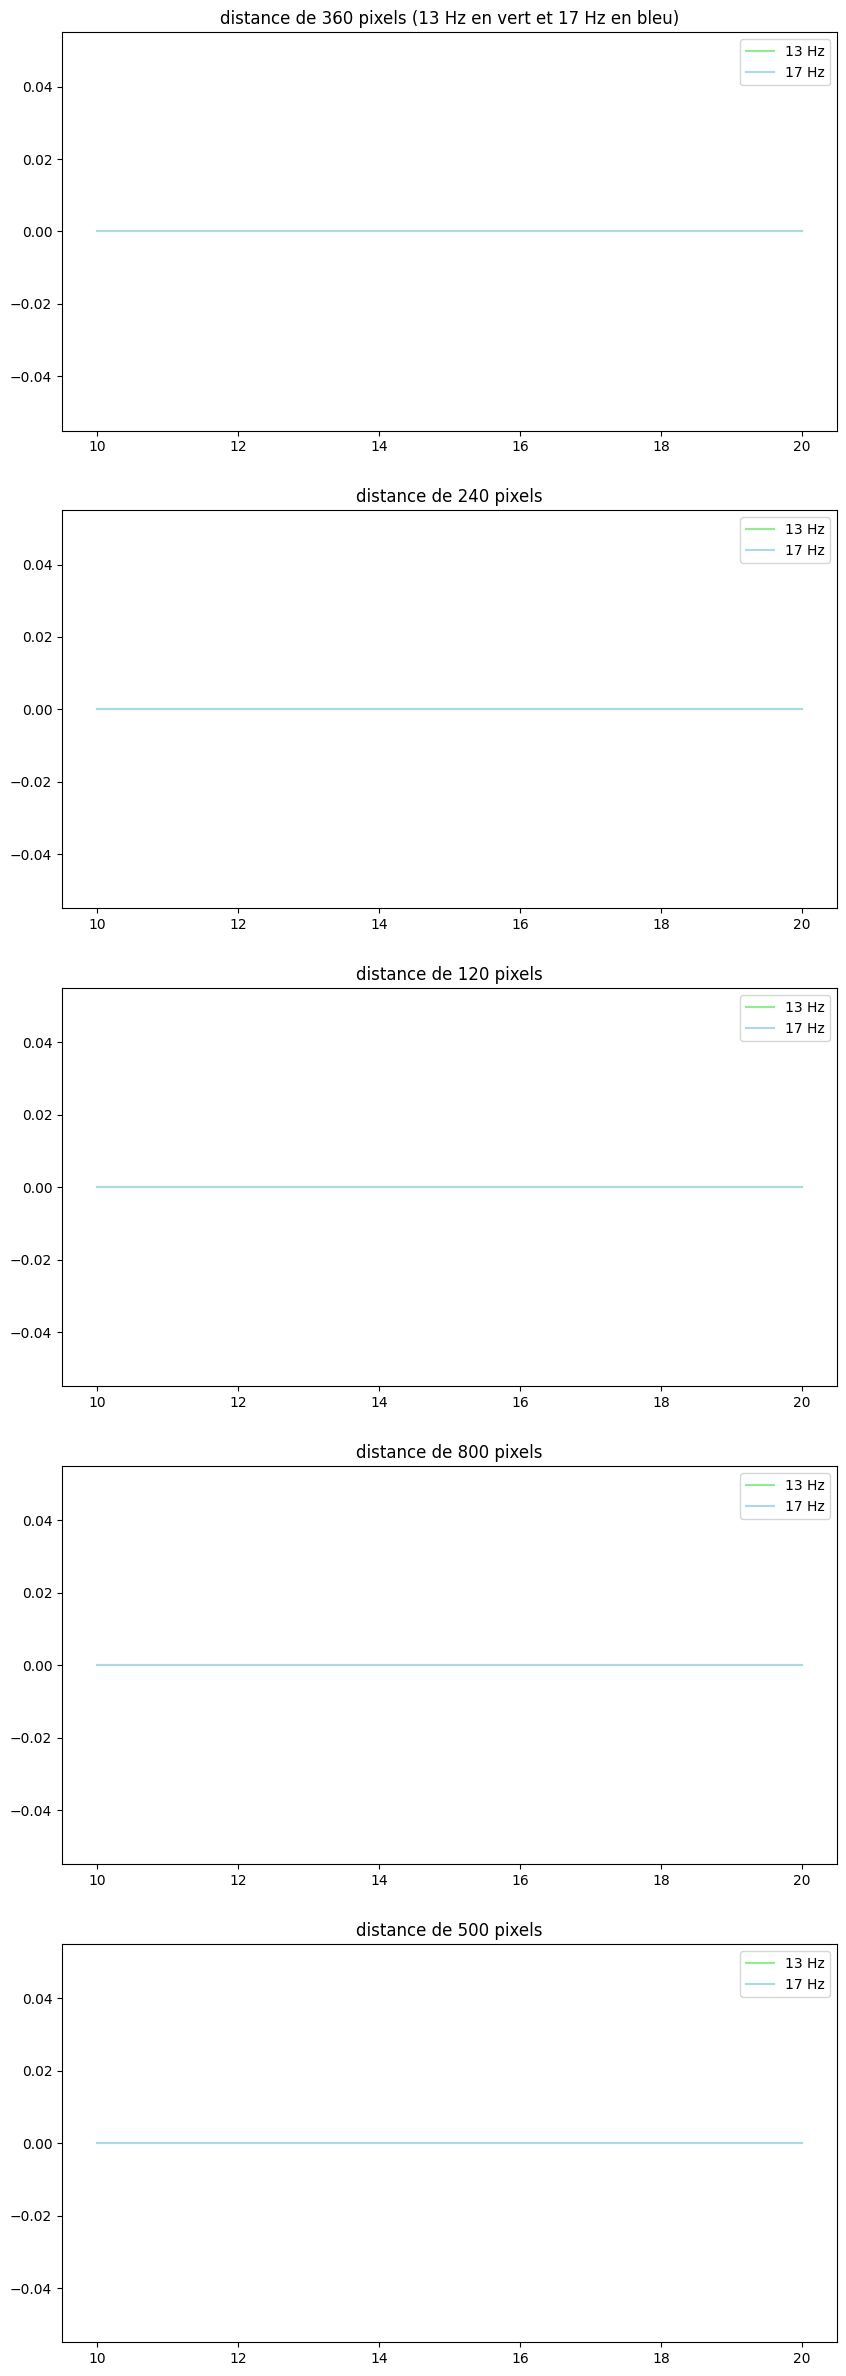

In [30]:
#moyennes pour les essais 4
psds_360 = np.zeros((6,len(frequency_bands)))
psds_240 = np.zeros((6,len(frequency_bands)))
psds_120 = np.zeros((6,len(frequency_bands)))
psds_800 = np.zeros((6,len(frequency_bands)))
psds_500 = np.zeros((6,len(frequency_bands)))

for k in range(42,42+6*5):
    if k < 42 + 6:
        if freq_to_check(k) == 13:
            psds_360[0] += all_psd[k]
        if freq_to_check(k) == 17:
            psds_360[1] += all_psd[k]
    if 42 + 6 < k < 42 + 12:
        if freq_to_check(k) == 13:
            psds_240[0] += all_psd[k]
        if freq_to_check(k) == 17:
            psds_240[1] += all_psd[k]
    if 42 + 12 < k < 42 + 18:
        if freq_to_check(k) == 13:
            psds_120[0] += all_psd[k]
        if freq_to_check(k) == 17:
            psds_120[1] += all_psd[k] 
    if 42 + 18 < k < 42 + 24:
        if freq_to_check(k) == 13:
            psds_800[0] += all_psd[k]
        if freq_to_check(k) == 17:
            psds_800[1] += all_psd[k]       
    if 42 + 24 < k < 42 + 30:
        if freq_to_check(k) == 13:
            psds_500[0] += all_psd[k]
        if freq_to_check(k) == 17:
            psds_500[1] += all_psd[k]


plt.figure(figsize=(10,30))
plt.subplot(5,1,1)
plt.plot(frequency_bands,psds_360[0],color='lightgreen',label='13 Hz')
plt.plot(frequency_bands,psds_360[1],color='lightblue',label = '17 Hz')
plt.legend()
plt.title("distance de 360 pixels (13 Hz en vert et 17 Hz en bleu)")
plt.subplot(5,1,2)
plt.plot(frequency_bands,psds_240[0],color='lightgreen',label = '13 Hz')
plt.plot(frequency_bands,psds_240[1],color='lightblue',label='17 Hz')
plt.legend()
plt.title("distance de 240 pixels")
plt.subplot(5,1,3)
plt.plot(frequency_bands,psds_120[0],color='lightgreen',label='13 Hz')
plt.plot(frequency_bands,psds_120[1],color='lightblue',label = '17 Hz')
plt.legend()
plt.title("distance de 120 pixels")
plt.subplot(5,1,4)
plt.plot(frequency_bands,psds_800[0],color='lightgreen',label = '13 Hz')
plt.plot(frequency_bands,psds_800[1],color='lightblue',label = '17 Hz')
plt.legend()
plt.title("distance de 800 pixels")
plt.subplot(5,1,5)
plt.plot(frequency_bands,psds_500[0],color='lightgreen',label = '13 Hz')
plt.plot(frequency_bands,psds_500[1],color='lightblue',label = '17 Hz')
plt.legend()
plt.title("distance de 500 pixels")


plt.show()

**Essai 2 traitement en enlevant les moyennes sur tout l'enregistrement**

In [27]:
window = 0.4
frequency_bands=[10,12,13,14,15,16,17,18,20]
psds_mean = [0]*len(frequency_bands)
for i in range(len(frequency_bands)):
    
    psds_signal, freqs_signal = mne.time_frequency.psd_welch(filt_raw,
                n_overlap=0, n_per_seg=None,
                tmin=reperes[0][0], tmax=reperes[reperes.shape[0]-1][1],
                fmin=frequency_bands[i]-window, fmax=frequency_bands[i]+window,
                average = 'median',window='boxcar',verbose=False)
    print(psds_signal, freqs_signal)
    psds_mean[i]=psds_signal.mean()
    

[[0.12793373]
 [0.04780859]
 [0.00237237]] [10.15625]
[[0.16969913]
 [0.06658632]
 [0.00364457]] [11.71875]
[[0.16277502]
 [0.06094289]
 [0.00335813]] [13.28125]
[[0.14050664]
 [0.06051002]
 [0.00327875]] [14.0625]
[[0.14315705]
 [0.05797796]
 [0.00345534]] [14.84375]
[[0.14533801]
 [0.05860403]
 [0.00357614]] [15.625]
[[0.16474704]
 [0.06411367]
 [0.00337137]] [17.1875]
[[0.1548289 ]
 [0.06154875]
 [0.00352539]] [17.96875]
[[0.15385122]
 [0.0590418 ]
 [0.00356366]] [20.3125]


In [31]:
all_psd = np.zeros((timing.shape[0],len(frequency_bands)))
for k in range(timing.shape[0]):
    period = k
    for i in range(len(frequency_bands)):
        psds, freqs = mne.time_frequency.psd_welch(filt_raw,
                n_overlap=0, n_per_seg=None,
                tmin=reperes[period][0], tmax=reperes[period][1],
                fmin=frequency_bands[i]-window, fmax=frequency_bands[i]+window,
                average = 'median', window='boxcar',verbose=False)
        all_psd[k][i] = np.abs(psds.mean()/psds_mean[i])

NameError: name 'psds_mean' is not defined

0
2
5
[1.11189076 0.69641069 0.91173553 0.85065709 0.79701335 0.78332561
 0.79927505 0.9112215  0.75222394] [0.66229601 0.80209053 0.86953586 0.82443608 0.83893821 1.08079661
 0.71411109 1.06892071 0.72673945]


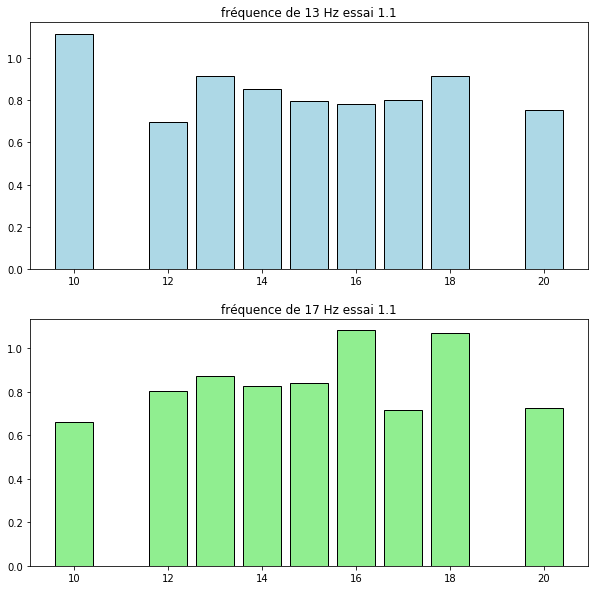

In [29]:
#moyenne pour l'essai 1.1
psds_13 = [0]*len(frequency_bands)
psds_17 = [0]*len(frequency_bands)
for k in range(6):
    if freq_to_check(k)==13:
        print(k)
        psds_13 += all_psd[k]
    if freq_to_check(k)==17:
        psds_17 += all_psd[k]
for i in range(len(frequency_bands)):
    psds_13[i]=psds_13[i]/3
    psds_17[i]=psds_17[i]/3

print(psds_13,psds_17)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.bar(frequency_bands,psds_13,color='lightblue',edgecolor='black')
plt.title("fréquence de 13 Hz essai 1.1")
plt.subplot(2,1,2)
plt.bar(frequency_bands,psds_17,color='lightgreen',edgecolor='black')
plt.title("fréquence de 17 Hz essai 1.1")
plt.show()

7
9
10
[0.67223224 1.15755593 0.82090555 1.21660943 0.77009056 0.63773217
 0.84708405 0.50136133 0.95584653] [0.5248416  0.60694185 0.57213372 0.58745885 0.81182541 0.93666572
 0.56564481 0.33309994 0.71026651]


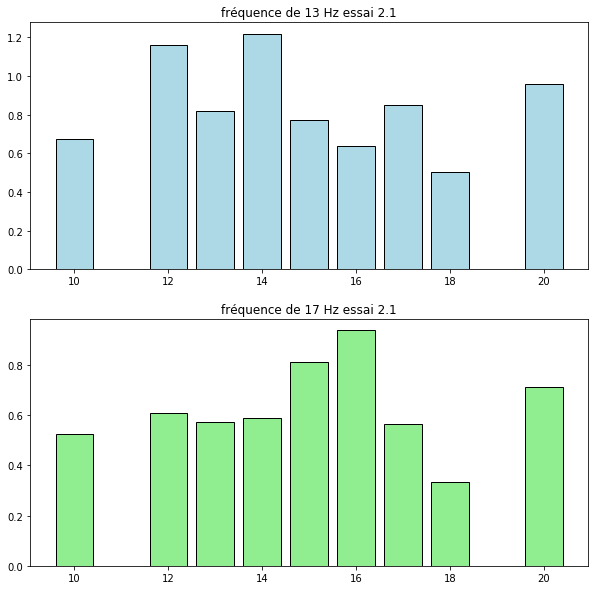

In [30]:
#moyenne pour l'essai 1.2
psds_13 = [0]*len(frequency_bands)
psds_17 = [0]*len(frequency_bands)
for k in range(6,12):
    if freq_to_check(k)==13:
        print(k)
        psds_13 += all_psd[k]
    if freq_to_check(k)==17:
        psds_17 += all_psd[k]
for i in range(len(frequency_bands)):
    psds_13[i]=psds_13[i]/3
    psds_17[i]=psds_17[i]/3 

print(psds_13,psds_17)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.bar(frequency_bands,psds_13,color='lightblue',edgecolor='black')
plt.title("fréquence de 13 Hz essai 2.1")
plt.subplot(2,1,2)
plt.bar(frequency_bands,psds_17,color='lightgreen',edgecolor='black')
plt.title("fréquence de 17 Hz essai 2.1")
plt.show()

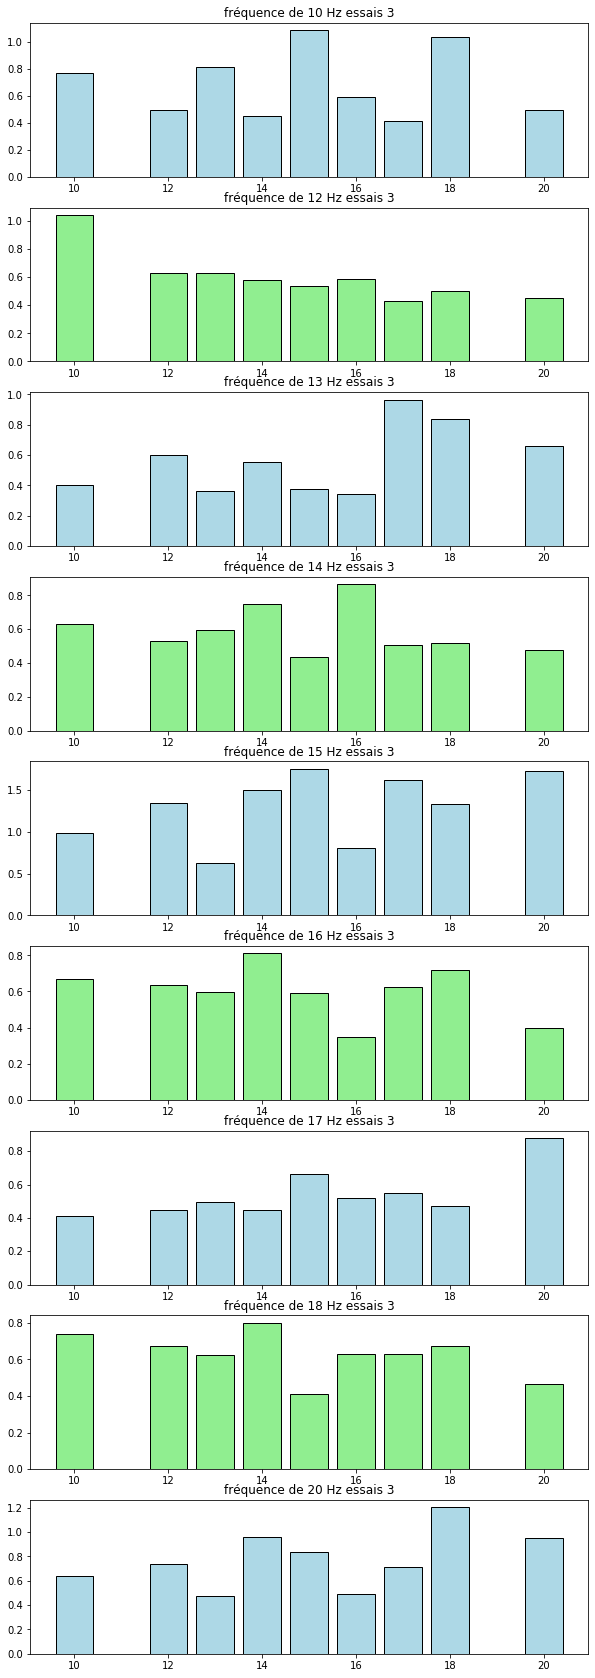

In [31]:
#moyennes pour les essais 3
psds_10 = [0]*len(frequency_bands)
psds_12 = [0]*len(frequency_bands)
psds_13 = [0]*len(frequency_bands)
psds_14 = [0]*len(frequency_bands)
psds_15 = [0]*len(frequency_bands)
psds_16 = [0]*len(frequency_bands)
psds_17 = [0]*len(frequency_bands)
psds_18 = [0]*len(frequency_bands)
psds_20 = [0]*len(frequency_bands)

for k in range(12,12+6*5):
    if freq_to_check(k)==10:
        psds_10 += all_psd[k]
    if freq_to_check(k)==12:
        psds_12 += all_psd[k]
    if freq_to_check(k)==13:
        psds_13 += all_psd[k]
    if freq_to_check(k)==14:
        psds_14 += all_psd[k]
    if freq_to_check(k)==15:
        psds_15 += all_psd[k]
    if freq_to_check(k)==16:
        psds_16 += all_psd[k]
    if freq_to_check(k)==17:
        psds_17 += all_psd[k]
    if freq_to_check(k)==18:
        psds_18 += all_psd[k]
    if freq_to_check(k)==20:
        psds_20 += all_psd[k]
for i in range(len(frequency_bands)):
    psds_10[i]=psds_10[i]/6
    psds_12[i]=psds_12[i]/6
    psds_13[i]=psds_13[i]/6
    psds_14[i]=psds_14[i]/6
    psds_15[i]=psds_15[i]/6
    psds_16[i]=psds_16[i]/6
    psds_17[i]=psds_17[i]/6
    psds_18[i]=psds_18[i]/6
    psds_20[i]=psds_20[i]/12



plt.figure(figsize=(10,30))
plt.subplot(9,1,1)
plt.bar(frequency_bands,psds_10,color='lightblue',edgecolor='black')
plt.title("fréquence de 10 Hz essais 3")
plt.subplot(9,1,2)
plt.bar(frequency_bands,psds_12,color='lightgreen',edgecolor='black')
plt.title("fréquence de 12 Hz essais 3")
plt.subplot(9,1,3)
plt.bar(frequency_bands,psds_13,color='lightblue',edgecolor='black')
plt.title("fréquence de 13 Hz essais 3")
plt.subplot(9,1,4)
plt.bar(frequency_bands,psds_14,color='lightgreen',edgecolor='black')
plt.title("fréquence de 14 Hz essais 3")
plt.subplot(9,1,5)
plt.bar(frequency_bands,psds_15,color='lightblue',edgecolor='black')
plt.title("fréquence de 15 Hz essais 3")
plt.subplot(9,1,6)
plt.bar(frequency_bands,psds_16,color='lightgreen',edgecolor='black')
plt.title("fréquence de 16 Hz essais 3")
plt.subplot(9,1,7)
plt.bar(frequency_bands,psds_17,color='lightblue',edgecolor='black')
plt.title("fréquence de 17 Hz essais 3")
plt.subplot(9,1,8)
plt.bar(frequency_bands,psds_18,color='lightgreen',edgecolor='black')
plt.title("fréquence de 18 Hz essais 3")
plt.subplot(9,1,9)
plt.bar(frequency_bands,psds_20,color='lightblue',edgecolor='black')
plt.title("fréquence de 20 Hz essais 3")

plt.show()

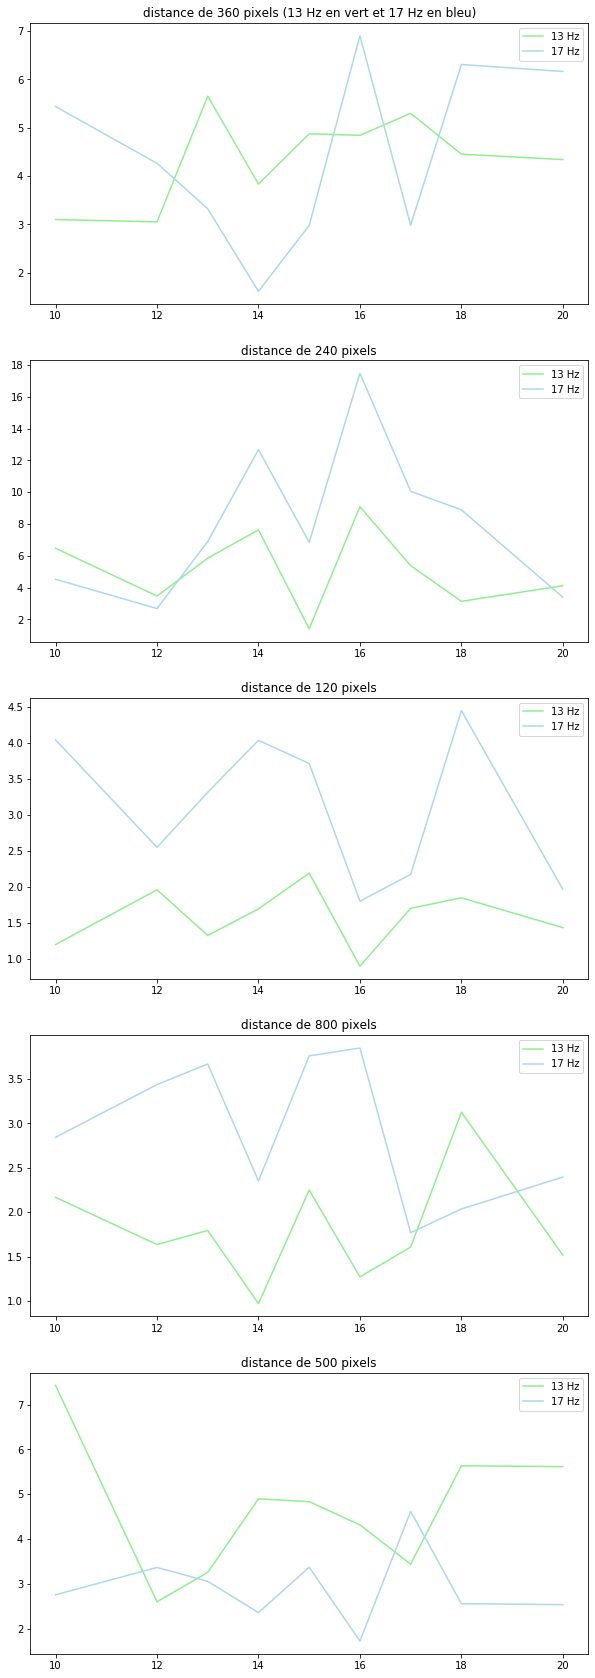

In [32]:
#moyennes pour les essais 4
psds_360 = np.zeros((6,len(frequency_bands)))
psds_240 = np.zeros((6,len(frequency_bands)))
psds_120 = np.zeros((6,len(frequency_bands)))
psds_800 = np.zeros((6,len(frequency_bands)))
psds_500 = np.zeros((6,len(frequency_bands)))

for k in range(42,42+6*5):
    if k < 42 + 6:
        if freq_to_check(k) == 13:
            psds_360[0] += all_psd[k]
        if freq_to_check(k) == 17:
            psds_360[1] += all_psd[k]
    if 42 + 6 < k < 42 + 12:
        if freq_to_check(k) == 13:
            psds_240[0] += all_psd[k]
        if freq_to_check(k) == 17:
            psds_240[1] += all_psd[k]
    if 42 + 12 < k < 42 + 18:
        if freq_to_check(k) == 13:
            psds_120[0] += all_psd[k]
        if freq_to_check(k) == 17:
            psds_120[1] += all_psd[k] 
    if 42 + 18 < k < 42 + 24:
        if freq_to_check(k) == 13:
            psds_800[0] += all_psd[k]
        if freq_to_check(k) == 17:
            psds_800[1] += all_psd[k]       
    if 42 + 24 < k < 42 + 30:
        if freq_to_check(k) == 13:
            psds_500[0] += all_psd[k]
        if freq_to_check(k) == 17:
            psds_500[1] += all_psd[k]


plt.figure(figsize=(10,30))
plt.subplot(5,1,1)
plt.plot(frequency_bands,psds_360[0],color='lightgreen',label='13 Hz')
plt.plot(frequency_bands,psds_360[1],color='lightblue',label = '17 Hz')
plt.legend()
plt.title("distance de 360 pixels (13 Hz en vert et 17 Hz en bleu)")
plt.subplot(5,1,2)
plt.plot(frequency_bands,psds_240[0],color='lightgreen',label = '13 Hz')
plt.plot(frequency_bands,psds_240[1],color='lightblue',label='17 Hz')
plt.legend()
plt.title("distance de 240 pixels")
plt.subplot(5,1,3)
plt.plot(frequency_bands,psds_120[0],color='lightgreen',label='13 Hz')
plt.plot(frequency_bands,psds_120[1],color='lightblue',label = '17 Hz')
plt.legend()
plt.title("distance de 120 pixels")
plt.subplot(5,1,4)
plt.plot(frequency_bands,psds_800[0],color='lightgreen',label = '13 Hz')
plt.plot(frequency_bands,psds_800[1],color='lightblue',label = '17 Hz')
plt.legend()
plt.title("distance de 800 pixels")
plt.subplot(5,1,5)
plt.plot(frequency_bands,psds_500[0],color='lightgreen',label = '13 Hz')
plt.plot(frequency_bands,psds_500[1],color='lightblue',label = '17 Hz')
plt.legend()
plt.title("distance de 500 pixels")


plt.show()